In [1]:
%load_ext autoreload
%autoreload 2
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from ag_utils import Corpus
from ag_utils import parse_ag_file
from ag_utils import parse_node_properties

from public_data import gene_dataset

from models import NN, GCN, GCN_EW, GAT
from model_utils import train, predict_prob, evaluate_performance

In [2]:
# parse attack graph file generated by MulVAL tool
attack_graph_path = '../mulval_attack_graph/AttackGraph.dot'
nodes, edges, node_properties = parse_ag_file(attack_graph_path)
node_dict = parse_node_properties(nodes, node_properties)

# save node label into corpus object
corpus = Corpus(node_dict)
num_tokens = corpus.get_num_tokens()
node_features = corpus.get_node_features()
node_types = corpus.get_node_types()
vocab_size = len(corpus.dictionary)
print('vocab_size: ', vocab_size)
print('num_tokens: ', num_tokens)
print('node_features shape: ', node_features.shape)


vocab_size:  57
num_tokens:  118
node_features shape:  torch.Size([26, 57])


In [3]:
# statistics of the encoded attack graph
num_nodes = len(nodes)
print('num_nodes: ', num_nodes)

num_node_features = node_features.shape[1]
print('num_node_features: ', num_node_features)

num_edges = len(edges)
print('num_edges: ', num_edges)

action_nodes = corpus.get_action_nodes()
action_node_idx = list(action_nodes.keys())
num_action_nodes = len(action_node_idx)
print('action_node_idx: ', action_node_idx)
print('num_action_nodes: ', num_action_nodes)

# var 'action_mask' is used to represent the attack scenarios in attack graph (i.e., the privilege nodes)
action_mask = action_node_idx


num_nodes:  26
num_node_features:  57
num_edges:  26
action_node_idx:  [0, 2, 4, 7, 9, 12, 14]
num_action_nodes:  7


In [4]:
# adj matrix and edge index
adj_matrix = torch.zeros(len(nodes), len(nodes))

for edge in edges:
    source_node, target_node = edge
    source_index = nodes.index(source_node)
    target_index = nodes.index(target_node)
    adj_matrix[source_index][target_index] = 1

edge_index = adj_matrix.nonzero().t().contiguous()

assert edge_index.shape[0]==2

In [5]:
# prepare Dataset 2
num_benign = 1500
num_malic = 500
sample_method = 'public'

X, Y= gene_dataset(action_node_idx, num_nodes, num_benign, num_malic)
rt_meas_dim = X.shape[2]

# associate node features in attack graph with real-time measurements
node_feat_ts = torch.stack([node_features for _ in range(len(X))], dim=0)
X = torch.cat((node_feat_ts, X), dim=2)

num_samples = X.shape[0]
print('num_samples: ', num_samples)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42, stratify=Y_train)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

num_samples:  5000
torch.Size([3000, 26, 135]) torch.Size([3000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7])


In [6]:
# load Dataset 2 used in the paper
data_path = '../datasets/public/'
X_train = torch.load(data_path+'X_train-{}.pth'.format(sample_method))
X_val   = torch.load(data_path+'X_val-{}.pth'.format(sample_method))
X_test  = torch.load(data_path+'X_test-{}.pth'.format(sample_method))
Y_train = torch.load(data_path+'Y_train-{}.pth'.format(sample_method))
Y_val   = torch.load(data_path+'Y_val-{}.pth'.format(sample_method))
Y_test  = torch.load(data_path+'Y_test-{}.pth'.format(sample_method))
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

torch.Size([3000, 26, 135]) torch.Size([3000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7]) torch.Size([1000, 26, 135]) torch.Size([1000, 7])


In [7]:

# hyperparameters for training
in_dim = X_train.shape[-1]
hidden_dim = 20
out_dim = 1
lr = 0.001
device = 'cuda'
# model initialization
models = {}
model_NN = NN(78, hidden_dim, out_dim)
model_GCN = GCN(in_dim, hidden_dim, out_dim)
model_GCN_EW = GCN_EW(in_dim, hidden_dim, out_dim, edge_index)
model_GAT = GAT(hidden_channels=hidden_dim, heads=4, in_dim=in_dim, out_dim=out_dim)

models['NN'] = model_NN
models['GCN'] = model_GCN
models['GCN-EW'] = model_GCN_EW
models['GAT'] = model_GAT
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)
X_test = X_test.to(device)
edge_index = edge_index.to(device)

for name, model in models.items():
    model.name = name
    model.action_mask = action_mask
    model = model.to(device)
    if hasattr(model, 'pos_weight') and model.pos_weight is not None:
        model.pos_weight = model.pos_weight.to(device)

    num_epochs = 500 # early stop when overfitting observed
    print(f'{model.name} start training...')
    time_start = time.time()
    print('model: ', model) 
    train(model, lr, num_epochs, X_train, Y_train, X_val, Y_val, edge_index, rt_meas_dim, device)       
    time_end = time.time()
    print('time cost: ', time_end - time_start)  
    print(f'{model.name} training finished!')

    print(f'{model.name} accuracy on training set: {model.stat["acc_train"][-1]}')
    print(f'{model.name} accuracy on validation set: {model.stat["acc_val"][-1]}')


NN start training...
model:  NN(
  (lin1): Linear(in_features=78, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=20, bias=True)
  (out_layer): Linear(in_features=20, out_features=1, bias=True)
)
Epoch: 010, Training Loss: 0.3188, Traning Accuracy: 0.9248, Validation Loss: 0.3184, Validation Accuracy: 0.9284
Epoch: 020, Training Loss: 0.1997, Traning Accuracy: 0.9571, Validation Loss: 0.2383, Validation Accuracy: 0.9564
Epoch: 030, Training Loss: 0.1649, Traning Accuracy: 0.9651, Validation Loss: 0.2232, Validation Accuracy: 0.9630
Epoch: 040, Training Loss: 0.1534, Traning Accuracy: 0.9674, Validation Loss: 0.2240, Validation Accuracy: 0.9657
Epoch: 050, Training Loss: 0.1450, Traning Accuracy: 0.9678, Validation Loss: 0.2257, Validation Accuracy: 0.9666
Epoch: 060, Training Loss: 0.1383, Traning Accuracy: 0.9705, Validation Loss: 0.2273, Validation Accuracy: 0.9687
Epoch: 070, Training Loss: 0.1287, Traning Accuracy: 0.9720, Validation Loss: 0.2253, Validati

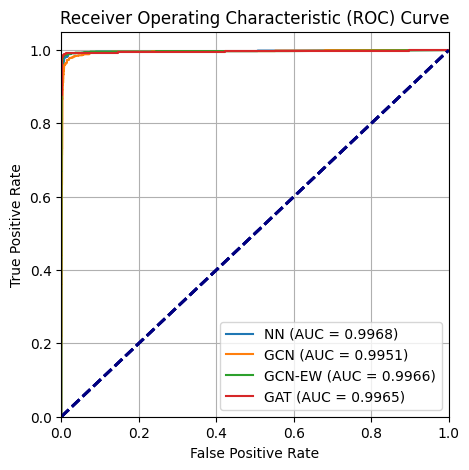

In [9]:
# plot the roc curve
from sklearn.metrics import roc_curve, auc
fig, ax = plt.subplots(figsize=(5, 5))

for name, model in models.items():
    # 1. 预测 (此时结果在 GPU 上)
    prob = predict_prob(model, X_test, edge_index)
    y_probs = prob.view(-1, 2)
    
    # === 2. 关键修改：把数据搬回 CPU 并切断梯度 ===
    y_true_cpu = Y_test.view(-1).cpu().detach().numpy()
    y_score_cpu = y_probs[:, 1].cpu().detach().numpy()
    # ==========================================

    # 3. 使用 CPU 数据计算 ROC
    fpr, tpr, thresholds = roc_curve(y_true_cpu, y_score_cpu)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label='{} (AUC = {:.4f})'.format(model.name, roc_auc))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend(loc="lower right")

ax.grid()
plt.show()

In [12]:
# === 重写评估函数以支持 GPU ===
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def evaluate_performance(models, X, y, edge_index, device):
    metrics = {}
    
    # 确保标签在 CPU 上，方便 sklearn 计算
    y_true_cpu = y.view(-1).cpu().detach().numpy()
    # 确保标签在 GPU 上，方便 torch 计算 accuracy
    y_gpu = y.to(device)

    for name, model in models.items():
        # 1. 预测 (在 GPU 上)
        prob = predict_prob(model, X, edge_index)
        pred_ts = torch.argmax(prob, dim=2)
        
        # 2. 计算 Accuracy (在 GPU 上做张量运算)
        accuracy = (pred_ts == y_gpu).sum().item() / (y.shape[0] * y.shape[1])
        
        # 3. 搬回 CPU 计算混淆矩阵等指标
        pred_cpu = pred_ts.view(-1).cpu().detach().numpy()
        
        # 计算指标
        conf_matrix = confusion_matrix(y_true_cpu, pred_cpu).flatten()
        precision, recall, f1, _ = precision_recall_fscore_support(y_true_cpu, pred_cpu, average='macro')
        
        # 4. 存入字典 (注意处理混淆矩阵形状)
        # 如果是二分类，flatten 后有 4 个值 (tn, fp, fn, tp)
        if len(conf_matrix) == 4:
            tn, fp, fn, tp = conf_matrix
        else:
            # 极端情况 (如全预测为0)，可能不满4个，做个容错
            tn, fp, fn, tp = 0, 0, 0, 0
            
        metrics[name] = {
            "TN": tn, "FP": fp, "FN": fn, "TP": tp,
            "precision": precision, "recall": recall, "f1": f1,
            "accuracy": accuracy,
            # 这里还有其他指标，如果原代码有用到，可以补充
        }
        
    return metrics

In [13]:
metrics = evaluate_performance(models, X_test, Y_test, edge_index, device)
df = pd.DataFrame(metrics)
print(df)

                    NN          GCN       GCN-EW          GAT
TN         6206.000000  6213.000000  6267.000000  6264.000000
FP           94.000000    87.000000    33.000000    36.000000
FN           13.000000    25.000000    13.000000    10.000000
TP          687.000000   675.000000   687.000000   690.000000
precision     0.938776     0.940910     0.976048     0.974410
recall        0.983254     0.975238     0.988095     0.990000
f1            0.959602     0.957230     0.981975     0.982042
accuracy      0.984714     0.984000     0.993429     0.993429


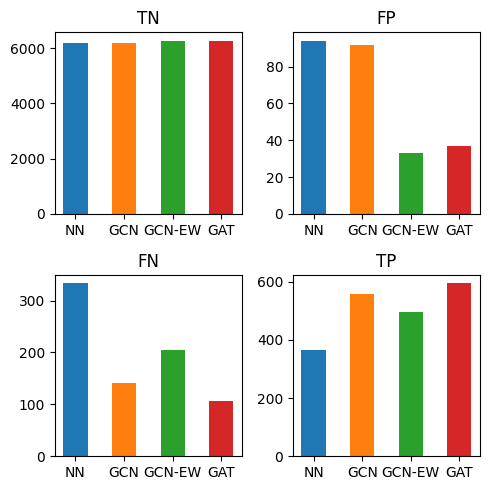

In [19]:
# plot the TP, FP, TN, FN for each model
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs = axs.ravel()

bar_width = 0.5
labels = ['TN', 'FP', 'FN', 'TP']
model_names = list(models.keys())

# === 自定义颜色列表 (匹配论文风格) ===
# 顺序对应: NN, GCN, GCN-EW, GAT
# 你可以根据喜好微调这些十六进制色值
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] 
# ===================================

for i, label in enumerate(labels):
    # 准备数据
    values = [metrics[name][label] for name in model_names]
    
    # 画柱状图，并在 bar() 函数中指定 color 参数
    # 注意：这里我们需要给每个柱子指定不同的颜色
    rects = axs[i].bar(np.arange(len(model_names)), values, width=bar_width, label=label, color=colors)
    
    # 设置刻度
    axs[i].set_xticks(np.arange(len(model_names)))
    axs[i].set_xticklabels(model_names)
    
    for tick in axs[i].xaxis.get_major_ticks():
        tick.label1.set_fontsize(10)
    axs[i].set_title(label)

plt.tight_layout()
plt.show()

In [16]:
# robustness evaluation
for i in range(Y_test.shape[0]):
    for j in range(len(action_mask)):
        if Y_test[i, j] == 1:
            for k in range(rt_meas_dim):
                X_test[i, action_mask[j],-rt_meas_dim+k] += torch.normal(mean=0, std=0.01, size=(1,)).item()

metrics = evaluate_performance(models, X_test, Y_test, edge_index, device)
df = pd.DataFrame(metrics)
print(df)

                    NN          GCN       GCN-EW          GAT
TN         6206.000000  6208.000000  6267.000000  6263.000000
FP           94.000000    92.000000    33.000000    37.000000
FN          333.000000   142.000000   205.000000   106.000000
TP          367.000000   558.000000   495.000000   594.000000
precision     0.872585     0.918050     0.952913     0.962360
recall        0.754683     0.891270     0.850952     0.921349
f1            0.799478     0.904084     0.893777     0.940637
accuracy      0.939000     0.966571     0.966000     0.979571


In [17]:
from torch_geometric.data import Data
from torch_geometric.explain import GNNExplainer, Explainer

# individual case analysis
found = False
while not found:
    indi_case_id = torch.randint(0, X_test.shape[0], (1,)).item()
    y_true = Y_test[indi_case_id]
    if y_true[2] != 0:
        found = True
        print('indi_case_id: ', indi_case_id)
indi_case_x = X_test[indi_case_id]

indi_case_id:  490


model prob_ts: 
 tensor([0.0000e+00, 8.5802e-13, 1.8702e-09, 1.1721e-23, 1.3643e-21, 0.0000e+00,
        1.1365e-14], device='cuda:0', grad_fn=<IndexBackward0>)
y_true:  tensor([0., 0., 1., 0., 0., 0., 0.])


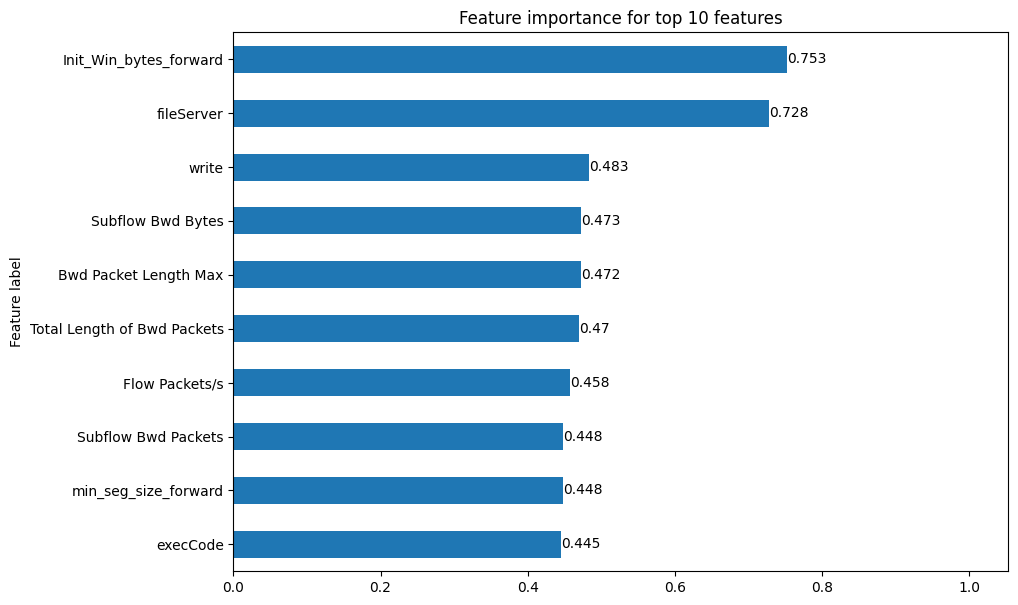

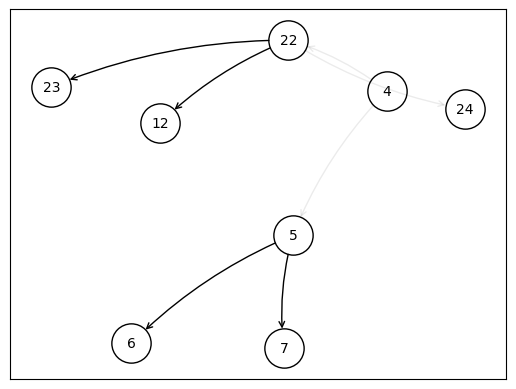

In [18]:
# Explainability visualization

model_to_explain = model_GCN_EW
model_to_explain.eval()
if model.name in ['GAT']:
    indi_case_x = indi_case_x.view(-1, in_dim)
prob_ts = torch.sigmoid(model_to_explain(indi_case_x, edge_index))[action_mask]

print('model prob_ts: \n', prob_ts)
print('y_true: ', y_true)

data = Data(x=X_test[indi_case_id], edge_index=edge_index)

explainer = Explainer(
    model=model_to_explain,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='raw',
    ),

)

feat_labels_ag = corpus.dictionary.idx2word.values()
feat_labels_ag = list(feat_labels_ag)
feat_labels_rtm = pd.read_csv('../datasets/public/CICIDS-2017.csv').columns.tolist()[:-1]
feat_labels_rtm = [feat.strip() for feat in feat_labels_rtm]
feat_labels = feat_labels_ag + feat_labels_rtm

compromised_node = action_node_idx[np.where(y_true==1)[0].item()]
explanation = explainer(data.x, data.edge_index, index=compromised_node)

explanation.visualize_feature_importance(feat_labels=feat_labels, top_k=10)
explanation.visualize_graph()